# **Palm Oil Tree Disease Detection**

### Split train Test
jangan di-run jika sudah ada folder train testnya

In [ ]:
import splitfolders # or import splitfolders
input_folder = "dataset"
output = "splitted-dataset" # where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.6, .4))

# then run augmentasi-image-dataset.ipynb

## Import Library

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import os

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from sklearn.metrics import confusion_matrix

## Dataset Preparation

Program ini dibuat untuk mengklasifikasikan 6 jenis daun kelapa sawit, berdasarkan penyakitnya :

1.   Capnodium
2.   Cochliobolus
3.   Culvaria
4.   Drecshlera
5.   Hara
6.   Normal

Dataset merupakan data sekunder yang didapatkan dari penelitian https://ojs.uma.ac.id/index.php/jite/article/view/4185. 
Program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasi.

### Import Dataset

Text(0.5, 1.0, 'normal')

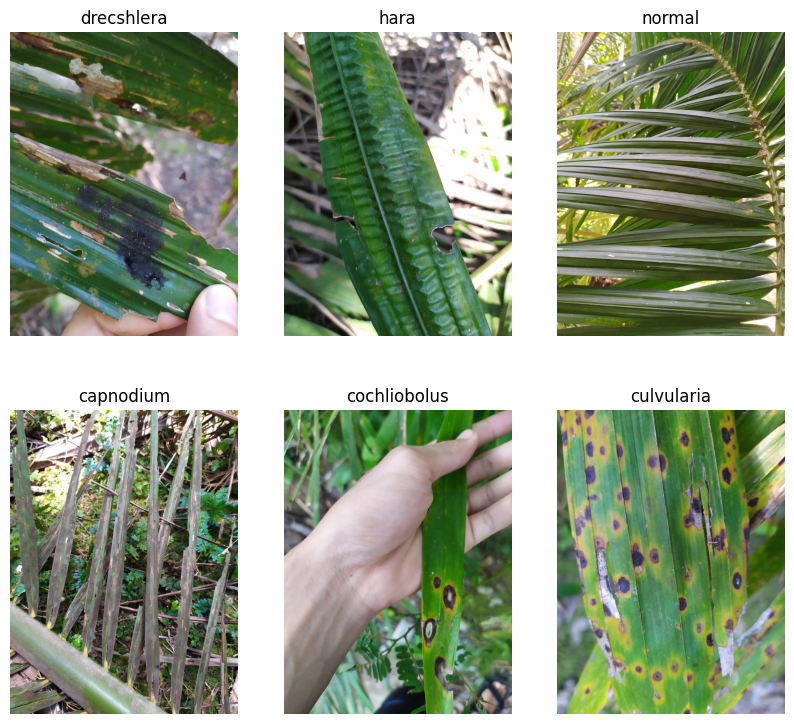

In [2]:
#Perintah untuk memvisualisasikan satu gambar dari data train
fig = plt.figure(figsize=(10, 18))
  
# setting values to rows and column variables
# rows = 1
columns = 3
  
# reading images
Image1 = imread('splitted-dataset/train/capnodium/capnodium2.jpg')
Image2 = imread('splitted-dataset/train/cochliobolus/cochliobolus2.jpg')
Image3= imread('splitted-dataset/train/culvularia/culvularia2.jpg')

Image4= imread('splitted-dataset/train/drecshlera/drecshlera2.jpg')
Image5= imread('splitted-dataset/train/hara/hara2.jpg')
Image6 = imread('splitted-dataset/train/normal/normal2.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(1, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("capnodium")
  
# Adds a subplot at the 2nd position
fig.add_subplot(1,columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("cochliobolus")
  
# Adds a subplot at the 3rd position
fig.add_subplot(1, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("culvularia")





fig.add_subplot(2,columns, 1)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("drecshlera")
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, columns, 2)
  
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("hara")
  
# Adds a subplot at the 3rd position
fig.add_subplot(2 ,columns, 3)
  
# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("normal")
  


In [3]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('splitted-dataset/train-augmented')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['capnodium', 'cochliobolus', 'culvularia','drecshlera', 'hara', 'normal']

for i,label in enumerate(labels):
    folder = os.path.join("splitted-dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 575 images belonging to 6 classes.
Found 141 images belonging to 6 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 6)
Bentuk array dari dataset validation (validasi) adalah: (128, 224, 224, 3) (128, 6)
Bentuk array dari dataset test (pengujian) adalah: (24, 224, 224, 3) (24,)


### Menyimpan Label

In [4]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'capnodium': 0, 'cochliobolus': 1, 'culvularia': 2, 'drecshlera': 3, 'hara': 4, 'normal': 5}


## Transfer Learning

In [5]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNetV3(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

AttributeError: module 'keras.api._v2.keras.applications' has no attribute 'MobileNetV3'

### Feature Extraction

Menggunakan model *pre-trained* untuk ekstraksi fitur (*feature extraction*) : Ketika bekerja dengan dataset kecil, adalah umum untuk mengambil keuntungan dari fitur yang dipelajari oleh model yang dilatih pada dataset yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat contoh model *pre-trained* dan menambahkan classifier yang sepenuhnya terhubung di atas. Model *pre-trained* adalah "beku" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusional mengekstraksi semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih classifier yang menentukan kelas gambar mengingat set fitur yang diekstraksi.

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Build CNN

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Mempersiapkan Data Masukan Pengujian

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

### Add Custom Layer

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          368672    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 2,626,854
Trainable params: 368,870
Non-

## Training

In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
# ckpt = ModelCheckpoint("Klasifikasi Wayang Kulit.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=val_generator)
# history = model.fit(train_generator, batch_size=120, epochs= 100,validation_data=val_generator,callbacks = [ckpt])

Epoch 1/10
5/5 [==============================] - 64s 12s/step - loss: 2.3411 - acc: 0.4157 - val_loss: 0.5225 - val_acc: 0.7518
Epoch 2/10
5/5 [==============================] - 43s 9s/step - loss: 0.3931 - acc: 0.8748 - val_loss: 0.1523 - val_acc: 0.9929
Epoch 3/10
5/5 [==============================] - 46s 10s/step - loss: 0.1154 - acc: 0.9878 - val_loss: 0.0431 - val_acc: 0.9929
Epoch 4/10
5/5 [==============================] - 40s 8s/step - loss: 0.0324 - acc: 0.9948 - val_loss: 0.0099 - val_acc: 1.0000
Epoch 5/10
5/5 [==============================] - 47s 9s/step - loss: 0.0151 - acc: 0.9983 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 6/10
5/5 [==============================] - 43s 8s/step - loss: 0.0115 - acc: 0.9983 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 7/10
5/5 [==============================] - 43s 9s/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 8/10
5/5 [==============================] - 36s 7s/step - loss: 0.0019 - acc: 1.0000 - val_loss:

### Training Visualization

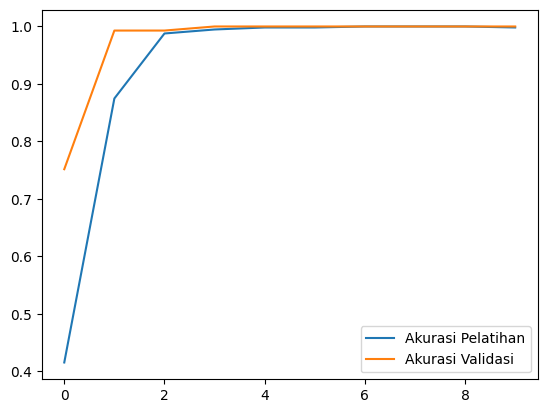

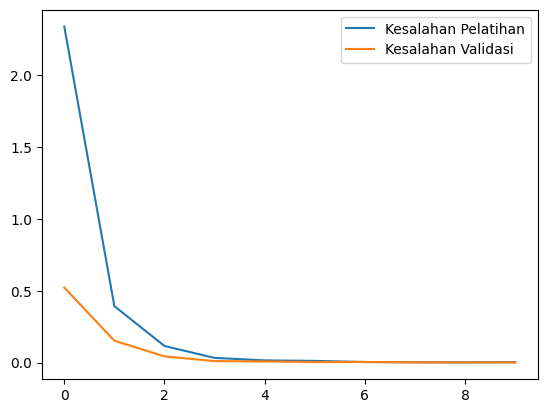

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Akurasi Validasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Kesalahan Validasi")
plt.legend()
plt.show()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


### Save model .h5

In [ ]:
model.save("save_model/model.h5")

In [ ]:
from tensorflow.keras.models import load_model
# model.load_('save_model/model4.h5')
model.load_weights('save_model/model.h5')

## Use Model

In [ ]:
#Prediksi Label Validasi dengan Pelatihan
n = 3
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 2s 2s/step
Prediksinya adalah [2.12e-08 3.96e-05 8.35e-04 6.76e-05 1.26e-21 9.99e-01]


## Evaluasi

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
5/5 [==============================] - 29s 5s/step - loss: 2.9648e-04 - acc: 1.0000
[0.00029648045892827213, 1.0]
2/2 [==============================] - 7s 557ms/step - loss: 7.8178e-04 - acc: 1.0000
[0.0007817806326784194, 1.0]
1/1 [==============================] - 1s 901ms/step - loss: 3.6442 - acc: 0.5833
[3.644192695617676, 0.5833333134651184]


In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

1/1 [==============================] - 1s 967ms/step
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[5 2 0 0 2 2 1 3 2 3 2 2 3 3 3 3 5 1 4 4 5 2 5 2]


### *Confusion Matrix*

Normalized confusion matrix
[[0.5  0.   0.25 0.   0.   0.25]
 [0.   0.25 0.5  0.25 0.   0.  ]
 [0.   0.   0.75 0.25 0.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.25 0.   0.   0.5  0.25]
 [0.   0.   0.5  0.   0.   0.5 ]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Label Prediksi', ylabel='Label Benar'>

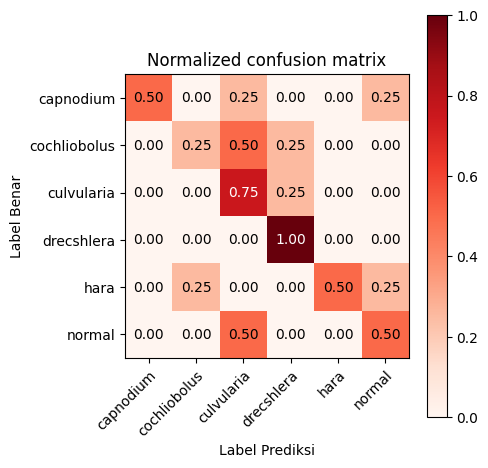

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      0.25      0.33         4
           2       0.38      0.75      0.50         4
           3       0.67      1.00      0.80         4
           4       1.00      0.50      0.67         4
           5       0.50      0.50      0.50         4

    accuracy                           0.58        24
   macro avg       0.67      0.58      0.58        24
weighted avg       0.67      0.58      0.58        24



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
print('Precision: %.3f' % precision_score(y_true, y_pred,average='weighted'))
print('Recall: %.3f' % recall_score(y_true, y_pred,average='weighted'))
print('F1 Score: %.3f' % f1_score(y_true, y_pred,average="weighted"))

Accuracy: 0.583
Precision: 0.674
Recall: 0.583
F1 Score: 0.578


In [ ]:
print((y_true))

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]


## Prediksi Gambar Individual

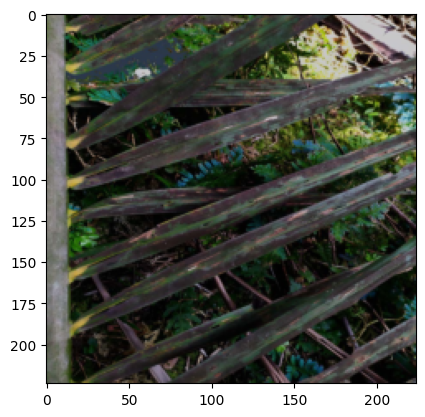

Label yang benar adalah: 0 : capnodium
1/1 [==============================] - 0s 81ms/step
Nilai yang diprediksi adalah: [9.18e-01 7.18e-03 7.08e-05 4.52e-02 1.94e-11 2.98e-02]
Label yang diprediksi adalah: 0 : capnodium
Prediksi benar


In [ ]:
n = 2 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")